# Hyperparameters Tuning в Azure ML

__Цель лабораторной работы:__

- __поиск оптимальных гиперпараметров__ модели машинного обучения (Hyperparameters Tuning)
- мониторинг процессса поиска.

## Подготовка среды

Импорт необходимых модулей и проверка версии Azure ML SDK:

In [2]:
import azureml.core
from azureml.core import Workspace, Model, Environment, Experiment, ComputeTarget, Dataset
from azureml.widgets import RunDetails

from azureml.train.sklearn import SKLearn

# Check core SDK version number
print(f'Azure ML SDK version: {azureml.core.VERSION}')

Azure ML SDK version: 1.14.0


Получим конфигурацию эксперимента: 

Зададим параметры Эксперимента:

In [18]:
%run core.py

config = get_experiment_config('lab_8A')
init_experiment(config)
experiment_dir = get_experiment_dir(config)

config

Experiment hyperparam-tuning-experiment was initialized successfully.


{'experiment_name': 'hyperparam-tuning-experiment',
 'working_subdir': 'hyperparam-tuning-experiment-lab',
 'core': {'expriments_root_dir': 'experiments/',
  'datastore_name': 'aml_ws_datastore_v2',
  'dataset_name': 'diabetes-data',
  'ml_cluster_name': 'aml-ws-cluster',
  'ml_model_name': 'diabetes-predict-model'}}

## Соединение со Azure ML Workspace

Устанавливаем соединение с Рабочей областью в Azure ML:

In [4]:
ws = Workspace.from_config()
print(f'Successfully connected to Workspace: {ws.name}.')

Successfully connected to Workspace: aml-workshop.


## Подготовка к обучению модели с поиском оптимальных гиперпараметров

### Получим данные

In [5]:
# Get list of all datasets
print([ds for ds in Dataset.get_all(ws)])

# Get diabetes dataset
data_ds = ws.datasets.get(config['core']['dataset_name'])
print(f'Used dataset {data_ds.name}: {data_ds.description}')

['diabetes-batch-data', 'MD-aml-designer-pipeline-Tune_Model_Hyperparameters-Trained_best_model-6dc9470c', 'diabetes-data', 'diabetes-data-ui']
Used dataset diabetes-data: Diabetes Disease Database


## Получим Среду запуска

In [6]:
# Get list of all eviraments
print([e for e in Environment.list(ws)])

# Get eviraments for diabetes train script
env = Environment.get(ws, 'environments-experiment')

['environments-experiment', 'AzureML-AutoML', 'AzureML-PyTorch-1.0-GPU', 'AzureML-Scikit-learn-0.20.3', 'AzureML-TensorFlow-1.12-CPU', 'AzureML-PyTorch-1.2-GPU', 'AzureML-TensorFlow-2.0-GPU', 'AzureML-TensorFlow-2.0-CPU', 'AzureML-Chainer-5.1.0-GPU', 'AzureML-TensorFlow-1.13-CPU', 'AzureML-Minimal', 'AzureML-Chainer-5.1.0-CPU', 'AzureML-PyTorch-1.4-GPU', 'AzureML-PySpark-MmlSpark-0.15', 'AzureML-PyTorch-1.3-CPU', 'AzureML-PyTorch-1.1-GPU', 'AzureML-TensorFlow-1.10-GPU', 'AzureML-PyTorch-1.2-CPU', 'AzureML-TensorFlow-1.13-GPU', 'AzureML-TensorFlow-1.10-CPU', 'AzureML-PyTorch-1.3-GPU', 'AzureML-PyTorch-1.4-CPU', 'AzureML-Tutorial', 'AzureML-PyTorch-1.0-CPU', 'AzureML-PyTorch-1.1-CPU', 'AzureML-TensorFlow-1.12-GPU', 'AzureML-VowpalWabbit-8.8.0', 'AzureML-Designer-VowpalWabbit', 'AzureML-TensorFlow-2.2-GPU', 'AzureML-TensorFlow-2.2-CPU', 'AzureML-PyTorch-1.6-CPU', 'AzureML-PyTorch-1.6-GPU', 'AzureML-Triton', 'AzureML-TensorFlow-2.3-CPU', 'AzureML-TensorFlow-2.3-GPU', 'AzureML-Sidecar', 'Az

### Получим ML  кластер

In [7]:
# Get list of all compute targets
print([comp.name for comp in ComputeTarget.list(ws)])

# Get ML cluster compute targets
cluster = ComputeTarget(workspace=ws, name=config['core']['ml_cluster_name'])

['aml-compute-vm', 'aml-designer-cc', 'aml-ws-cluster']


### Скопируем скрипт обучения модели

In [8]:
!cp scripts/train_model.py $experiment_dir
!ls $experiment_dir

train_model.py


## Запустим эксперимент по оптимизации гиперпараметров модели

In [ ]:
from azureml.train.hyperdrive import BayesianParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal, uniform

params = BayesianParameterSampling(
    {
        '--reg_rate': uniform(0.01, 1.0)
    }
)

# Create an estimator
estimator = SKLearn(source_directory=experiment_dir,
                    inputs=[data_ds.as_named_input('data')], 
                    entry_script='train_model.py',
                    compute_target=cluster,
                    environment_definition=env)

# Configure hyperdrive settings
hd_config = HyperDriveConfig(estimator=estimator, 
                             hyperparameter_sampling=params, 
                             policy=None, 
                             primary_metric_name='AUC', 
                             primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                             max_total_runs=16,
                             max_concurrent_runs=4)

# Run the experiment
experiment = Experiment(workspace=ws, name=config['experiment_name'])
run = experiment.submit(config=hd_config)

# Show the status in the notebook as the experiment runs
RunDetails(run).show()
run.wait_for_completion()

Просмотрите детали выполнения Тюнинга гиперпараметров в виджете `RunDetails` или на портале Azure ML:

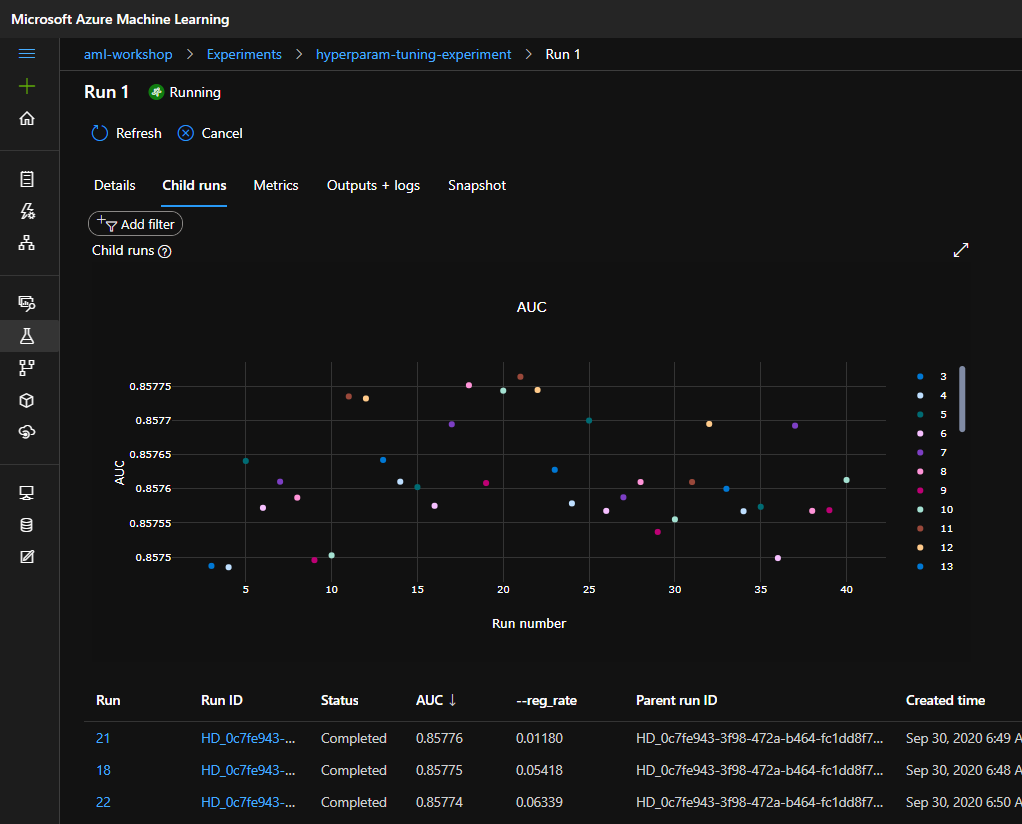

## Определение и регистрация 'лучшей' модели 

In [24]:
print('All runs:')
for child_run in run.get_children_sorted_by_primary_metric():
    print(f'\t{child_run}')

print('\n')

best_run = run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
parameter_values = best_run.get_details() ['runDefinition']['arguments']

print(f'Best Run Id: {best_run.id}')
print(f'\t AUC: {best_run_metrics["AUC"]}')
print(f'\t Accuracy: {best_run_metrics["Accuracy"]}')
print(f'\t Regularization Rate: {parameter_values}')

All runs:
	{'run_id': 'HD_0c7fe943-3f98-472a-b464-fc1dd8f7e8a7_18', 'hyperparameters': '{"--reg_rate": 0.01180349673025591}', 'best_primary_metric': 0.8577637701480314, 'status': 'Completed'}
	{'run_id': 'HD_0c7fe943-3f98-472a-b464-fc1dd8f7e8a7_15', 'hyperparameters': '{"--reg_rate": 0.05417939537416844}', 'best_primary_metric': 0.8577513618145945, 'status': 'Completed'}
	{'run_id': 'HD_0c7fe943-3f98-472a-b464-fc1dd8f7e8a7_19', 'hyperparameters': '{"--reg_rate": 0.06339099527035905}', 'best_primary_metric': 0.8577444131478701, 'status': 'Completed'}
	{'run_id': 'HD_0c7fe943-3f98-472a-b464-fc1dd8f7e8a7_17', 'hyperparameters': '{"--reg_rate": 0.06417512692775314}', 'best_primary_metric': 0.8577434204811951, 'status': 'Completed'}
	{'run_id': 'HD_0c7fe943-3f98-472a-b464-fc1dd8f7e8a7_8', 'hyperparameters': '{"--reg_rate": 0.1246442399685795}', 'best_primary_metric': 0.8577349828144581, 'status': 'Completed'}
	{'run_id': 'HD_0c7fe943-3f98-472a-b464-fc1dd8f7e8a7_9', 'hyperparameters': '{"--r

In [22]:
# Register model
best_run.register_model(model_path='outputs/model.pkl', 
                        model_name=config['core']['ml_model_name'],
                        tags={'Lab':'8A'},
                        properties={'AUC': best_run_metrics['AUC'], 'Accuracy': best_run_metrics['Accuracy']})

# List registered models
for model in Model.list(ws):
    print(f'{model.name} v{model.version}')
    
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print(f'\t {tag_name}: {tag}')
        
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print(f'\t {prop_name}: {prop}')
        
    print('\n')

diabetes-predict-model v4
	 Lab: 8A
	 AUC: 0.8577637701480314
	 Accuracy: 0.7886666666666666


diabetes-predict-model v3
	 Lab: 5A


diabetes-predict-model v2
	 Lab: 5B
	 AUC: 0.8576173518134779
	 Accuracy: 0.787


diabetes-predict-model v1
	 Lab: 4B
	 AUC: 0.8576982541474856
	 Accuracy: 0.7876666666666666




## Полезные ссылки

1. https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters
2. https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.hyperdrive.hyperdriveconfig?view=azure-ml-py
